In [1]:
import os
from collections import defaultdict
import numpy as np
import pandas as pd
import sklearn as skl
from scipy.interpolate import UnivariateSpline

In [2]:
# %matplotlib notebook
import matplotlib.pyplot as plt

# SETUP CONFIG

In [3]:
class ENV_CFG:
    class FILESYSTEM:
      SRC_ROOT = '../epidemiology'
      DATA_ROOT = '../data/kq'

#  METHOD DEFINITIONS

In [4]:
def getDayZero(dataDf):
    '''
    Finds day zero - the day before the first non-zero count is observed in the series
    '''
    dayZero = ''
    for rowId, rowVal in dataDf.items():
        if rowVal==0:
            dayZero=rowId
        else:
            if dayZero=='':
                dayZero=rowId
            dayZeroIdx = list(dataDf.index).index(dayZero)
            return dayZeroIdx, dayZero
    dayZeroIdx = list(dataDf.index).index(dayZero)
    return dayZeroIdx, dayZero

In [5]:
def getDerivatives(dataSeries):
    '''
    Finds derivatives of the series
    '''
    y_spl = UnivariateSpline(range(len(dataSeries)),dataSeries,s=0,k=4)
    x_range = range(len(dataSeries))
    
    derivatives={'x_range':x_range}
    derivatives[1] = y_spl.derivative(n=1)(x_range)
    derivatives[2] = y_spl.derivative(n=2)(x_range)
    return derivatives

In [6]:
def regionalPlots(dataDf, regionName):
    '''
    Plots cumulative curves and velocity/acceleration curves for a particular region in the data
    '''
    regionalDataDf=dataDf['confirmed'].loc[regionName]
    dayZeroIdx,dayZero = getDayZero(regionalDataDf)
    
    datapoints = ['confirmed', 'deaths']
    datapointColors = ['black', 'red']
    
    fig, axs = plt.subplots(1, 2, figsize=(15,5))
    for datapointIdx in range(len(datapoints)):
        datapoint=datapoints[datapointIdx]
        datapointColor = datapointColors[datapointIdx]
        regionalDatapointDf=dataDf[datapoint]
        axs[0].plot(regionalDatapointDf.loc[regionName].iloc[dayZeroIdx:], label=datapoint, color=datapointColor)
    axs[0].legend()
    axs[0].set_title('ABSOLUTE REPORTING')
    axs[0].set_xlabel('REPORTING DATE')
    axs[0].set_ylabel('CUMULATIVE COUNT')
    
    confirmedCasesCum = dataDf['confirmed'].loc[regionName].iloc[dayZeroIdx:]
    casesPerDay = []
    for i in range(1, len(confirmedCasesCum)):
        casesPerDay.append(confirmedCasesCum[i]-confirmedCasesCum[i-1])
    #Velocity/Acceleration Curve Plotting
    derivatives = getDerivatives(casesPerDay)

    axs[1].plot(derivatives['x_range'],casesPerDay, label='velocity', color='black')
    axs[1].set_ylabel('VELOCITY (CASES/DAY)')
    
    ax2 = axs[1].twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('ACCELERATION (CASES/DAY^2)', color='red')  # we already handled the x-label with ax1
    ax2.plot(derivatives['x_range'],[0]+derivatives[1], label='acceleration', color='red')
    
    yAxisLimits = (min(axs[1].get_ylim()[0], ax2.get_ylim()[0]), max(axs[1].get_ylim()[1], ax2.get_ylim()[1]))
    axs[1].set_ylim(yAxisLimits)
    ax2.set_ylim(yAxisLimits)
    axs[1].set_title('CONFIRMED CASES VELOCITY/ACCELERATION PLOT')
    axs[1].set_xlabel('DAY')
    
    plt.show()

#  WORLDWIDE DATA

In [7]:
worldData = {}
for datapoint in ['confirmed', 'deaths']:
    worldData[datapoint] = pd.read_csv(
        os.path.join(ENV_CFG.FILESYSTEM.DATA_ROOT, 'WORLD', 'time_series_' + datapoint+'.csv'),
        sep=',',
        header=0,
        index_col=0
    )

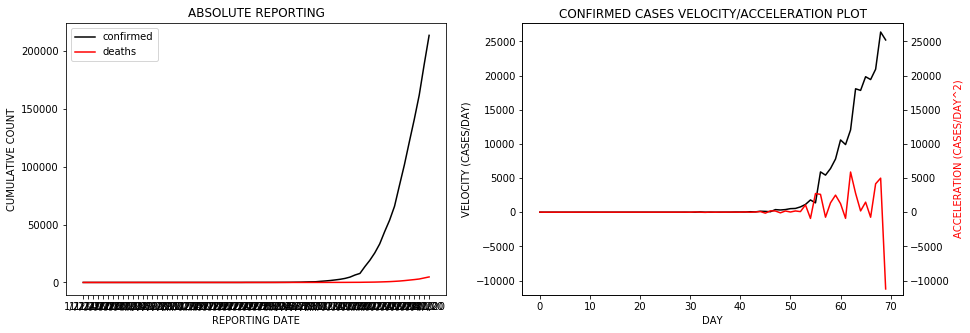

In [8]:
regionalPlots(worldData, regionName='US')

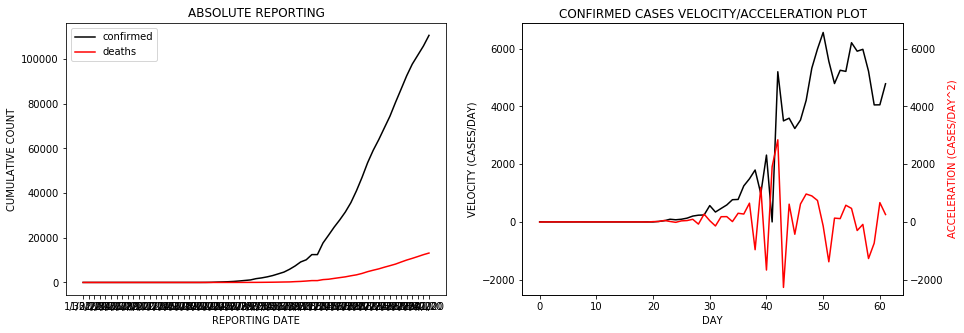

In [9]:
regionalPlots(worldData, regionName='Italy')

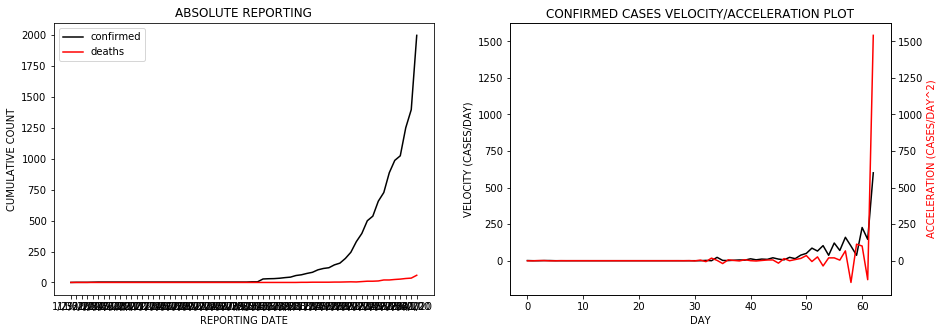

In [10]:
regionalPlots(worldData, regionName='India')

#  USA STATE DATA

In [11]:
usaStateData = {}
for datapoint in ['confirmed', 'deaths']:
    temp = pd.read_csv(
        os.path.join(ENV_CFG.FILESYSTEM.DATA_ROOT, 'US', 'state', 'time_series_' + datapoint+'.csv'),
        sep=',',
        header=0,
        index_col=0
    )    
    temp.drop(['UID','iso2','iso3','code3','FIPS','Combined_Key', 'Population'], axis=1, inplace=True,errors='ignore')
    usaStateData[datapoint]=temp

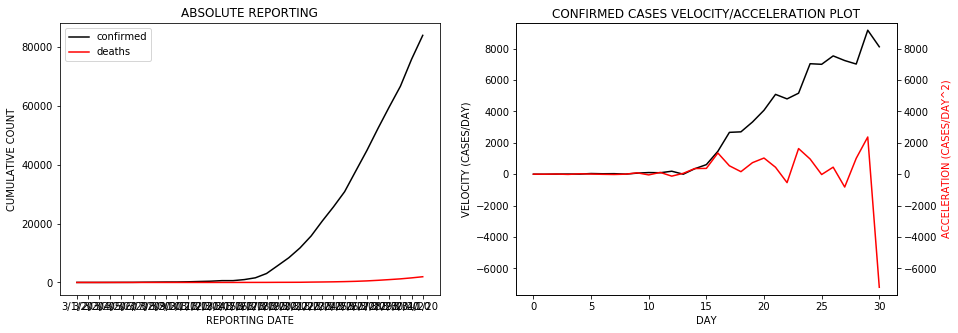

In [12]:
regionalPlots(usaStateData, regionName='New York')

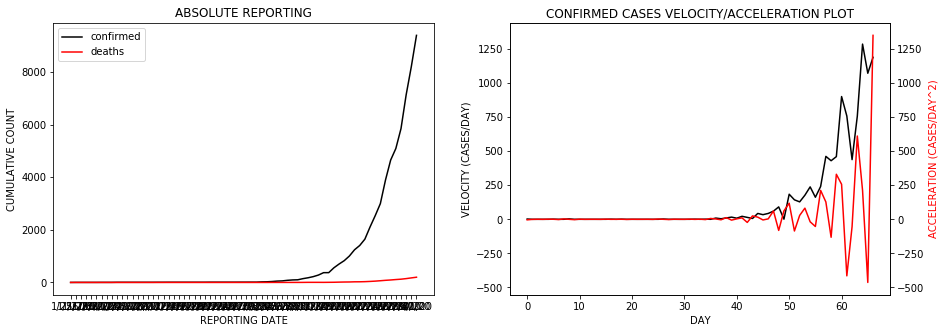

In [13]:
regionalPlots(usaStateData, regionName='California')

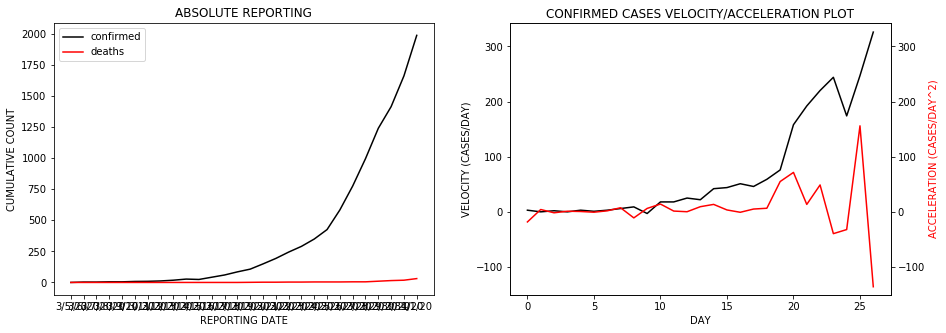

In [14]:
regionalPlots(usaStateData, regionName='Maryland')

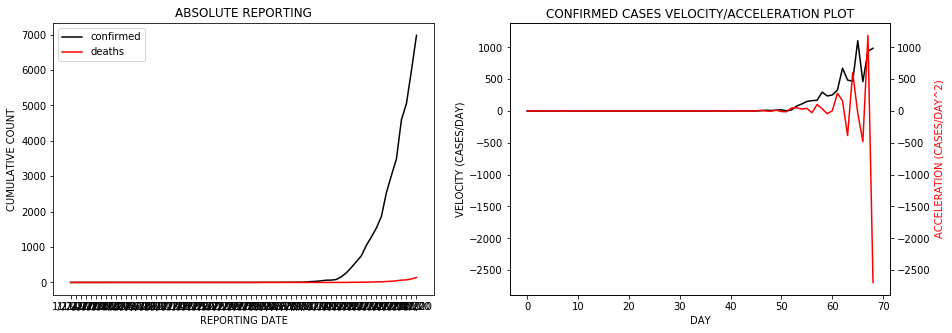

In [15]:
regionalPlots(usaStateData, regionName='Illinois')

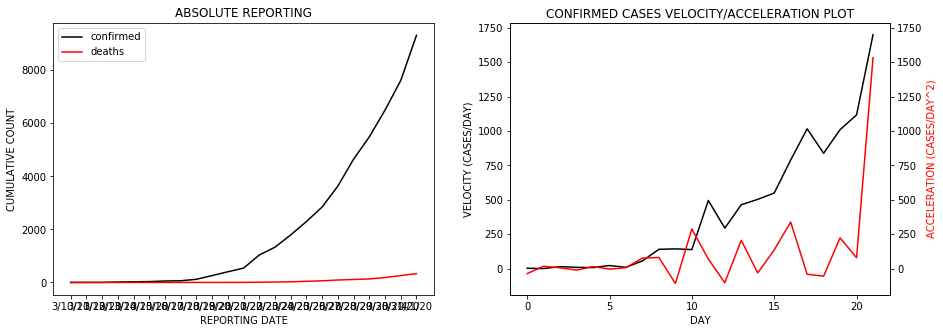

In [16]:
regionalPlots(usaStateData, regionName='Michigan')

#  USA COUNTY DATA

In [17]:
usaCountyData = {}
for datapoint in ['confirmed', 'deaths']:
    temp = pd.read_csv(
        os.path.join(ENV_CFG.FILESYSTEM.DATA_ROOT, 'US', 'county', 'time_series_' + datapoint+'.csv'),
        sep=',',
        header=0,
        index_col=0
    )
    temp.drop(['UID','iso2','iso3','code3','FIPS','Province_State','Combined_Key', 'Population'], axis=1, inplace=True,errors='ignore')
    usaCountyData[datapoint]=temp
    

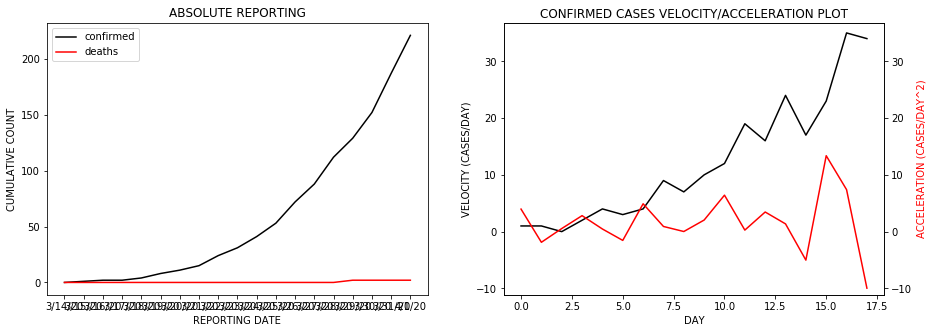

In [18]:
regionalPlots(usaCountyData, regionName='Baltimore City')